## Divvy Bike Data<br>
<br>

The objective of this part of the project is to help the Mayor of Chicago to better understand the ridership of Divvy Bike, a Chicago's bike-sharing system that has continued to grow since its birth in 2013. Furthermore, the mayor is hoping to boost Divvy Bike’s feasibility by adding the trip duration feature into their system. Thus, besides exploratory data analysis, we would build a predictive model which take the start station and destination station as input and return the prediction of trip duration as result.<br>

To start the EDA, you'll need to download the Divvy_Stations_2017_Q1Q2.csv, Divvy_Stations_2017_Q3Q4 and Divvy_Trips_2017_Q1 to Q4 datasets from [Divvy Bike Website](https://www.divvybikes.com/system-data) . 
Also, you need to read in the weather data weather_clean.csv which I downloaded from [NOAA Climate Data](https://www.ncdc.noaa.gov/cdo-web/) and cleaned it.<br>

<br>
The packages require for EDA include: pandas, numpy, datetime matplotlib, seaborn, geopy. In the end of this notebook, we'll output the Divvy_Trips_Model.csv file for the modeling part of the project.<br>

In [8]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

from geopy.distance import distance

import warnings
warnings.filterwarnings("ignore")

### Read in datasets

In [2]:
# Trips dataset
# read in csv file and concat quarterly data into one dataset
df1 = pd.read_csv('Divvy_Trips_2017_Q1.csv',parse_dates=['start_time','end_time'])
df2 = pd.read_csv('Divvy_Trips_2017_Q2.csv',parse_dates=['start_time','end_time'])
df3 = pd.read_csv('Divvy_Trips_2017_Q3.csv',parse_dates=['start_time','end_time'])
df4 = pd.read_csv('Divvy_Trips_2017_Q4.csv',parse_dates=['start_time','end_time'])
frames = [df1, df2, df3, df4]
df = pd.concat(frames)

In [3]:
# Stations dataset
# read in csv file and concat quarterly data into one dataset
st1 = pd.read_csv("Divvy_Stations_2017_Q1Q2.csv",parse_dates=['online_date'])
st2 = pd.read_csv("Divvy_Stations_2017_Q3Q4.csv",parse_dates=['online_date'])
st2 = st2.drop(columns = [st2.columns[-1]])
fr = [st1,st2]
st = pd.concat(fr, ignore_index=True)

In [4]:
# Weather dataset
wh = pd.read_csv('weather_clean.csv',parse_dates=['DATE'])

### Prepare the dataset for EDA

In [185]:
# modify the datset to do EDA
df['age'] = df.birthyear.apply(lambda x: 2017.0-x) # get the age from birthyear
df.tripduration = df.tripduration/60.0 # turn trip duration in minutes base
df = df.drop('birthyear',axis = 1)

In [186]:
# merge the station dataset
st2 = st[['id','latitude','longitude']].rename(columns = {'latitude':'from_latitude',
                                                          'longitude':'from_longitude'})
st3 = st[['id','latitude','longitude']].rename(columns = {'latitude':'to_latitude',
                                                          'longitude':'to_longitude'})
df = df.merge(st2, how='left', left_on = 'from_station_id', right_on = 'id')
df = df.merge(st3, how='left', left_on = 'to_station_id', right_on = 'id')
df = df.drop_duplicates(subset=['trip_id']).reset_index(drop=True)
df = df.drop(columns=['id_x','id_y'])

In [189]:
# calculate distance (miles)
def get_distance(x):
    '''
    This function return travel distance in miles for each row
    '''
    return distance(x['from'], x['to']).miles

df['from'] = list(zip(df.from_latitude, df.from_longitude))
df['to'] = list(zip(df.to_latitude, df.to_longitude))
df['dis_travel'] = df.apply(get_distance, axis=1)

In [190]:
# calculate speed (miles/hr)
def get_speed(x):
    """
    This function return the speed of each trip
    """
    return x['dis_travel']/(x['tripduration']/60.0)

df['speed'] = df.apply(get_speed,axis=1)

In [191]:
df.shape # now the datasets has 3829003 unique trips entry

(3829003, 20)

In [192]:
df.columns

Index(['trip_id', 'start_time', 'end_time', 'bikeid', 'tripduration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'age', 'from_latitude',
       'from_longitude', 'to_latitude', 'to_longitude', 'from', 'to',
       'dis_travel', 'speed'],
      dtype='object')

### EDA

#### 1)	Top 5 stations with the most starts (showing # of starts)

In [193]:
q1 = pd.DataFrame(df.groupby(['from_station_id','from_station_name'])['from_station_name'].count().sort_values(ascending=False).head())
q1 = q1.rename(columns = {'from_station_name':'number_of_trips'}).reset_index()
q1

,from_station_id,from_station_name,number_of_trips
0,35,Streeter Dr & Grand Ave,97569
1,76,Lake Shore Dr & Monroe St,53398
2,192,Canal St & Adams St,50911
3,91,Clinton St & Washington Blvd,49832
4,177,Theater on the Lake,47908


Text(0.5, 1.0, 'Top 5 Start Stations')

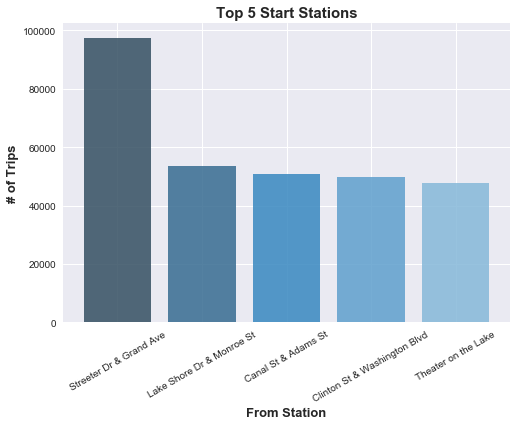

In [194]:
plt.bar(q1.from_station_name,q1.number_of_trips, color =sns.color_palette("Blues_d",5), alpha = 0.85)
plt.xticks(rotation=30)
plt.xlabel('From Station', fontsize = 13, weight = 'bold')
plt.ylabel('# of Trips', fontsize = 13, weight = 'bold')
plt.title('Top 5 Start Stations', fontsize = 15, weight = 'bold')

#### 2)	Trip duration by user type

In [195]:
q2_mean = df.groupby('usertype').tripduration.describe().iloc[:,[0,1,5]]
q2_total_hour = df.groupby('usertype').tripduration.sum()/60
q2 = q2_mean.join(q2_total_hour)
q2 = q2.rename(columns = {'count': 'total_trips_number',
                        'mean':'avg_minutes',
                         '50%': 'median_minutes',
                         'tripduration': 'total_hours'})
q2

,total_trips_number,avg_minutes,median_minutes,total_hours
usertype,,,,
Customer,836861.0,30.934833,22.816667,431469.260278
Dependent,7.0,12.530952,13.400000,1.461944
Subscriber,2992135.0,11.729794,9.533333,584952.101667


#### 3)	Most popular trips based on start station and stop station

In [196]:
q3 = pd.DataFrame(df.groupby(['from_station_name', 'to_station_name'])['to_station_name'].count().sort_values(ascending=False).head())
q3

to_station_name
from_station_name          to_station_name                            
Lake Shore Dr & Monroe St  Streeter Dr & Grand Ave               12171
Streeter Dr & Grand Ave    Streeter Dr & Grand Ave               10042
                           Theater on the Lake                    8180
                           Lake Shore Dr & North Blvd             7993
Lake Shore Dr & North Blvd Streeter Dr & Grand Ave                7226

#### 5)	What is the busiest bike in Chicago in 2017? How many times was it used? How many minutes was it in use?

In [197]:
q5 = df.pivot_table(index = 'bikeid',
                   values=['trip_id','tripduration'],
                   aggfunc={'trip_id':'count','tripduration':np.sum}).rename(columns = {'trip_id':'times_used'})

In [198]:
q5.sort_values(by= 'times_used',ascending = False).head()

,times_used,tripduration
bikeid,,
2565,1489,22526.416667
3308,1234,17662.633333
3489,1225,17617.466667
3128,1210,18244.300000
5880,1177,20693.900000


In [199]:
q5.sort_values(by= 'tripduration',ascending = False).head()

,times_used,tripduration
bikeid,,
2565,1489,22526.416667
5880,1177,20693.900000
5293,1049,19865.416667
5479,1044,19569.183333
5731,1027,19356.550000


#### 4) Rider performance by Gender and Age based on avg trip distance (station to station), median speed (distance traveled / trip duration)

In [211]:
df.isnull().sum(0) #there missing values for gender and age

trip_id              0
start_time           0
end_time             0
bikeid               0
tripduration         0
from_station_id      0
from_station_name    0
to_station_id        0
to_station_name      0
usertype             0
gender               0
age                  0
from_latitude        0
from_longitude       0
to_latitude          0
to_longitude         0
from                 0
to                   0
dis_travel           0
speed                0
dtype: int64

In [204]:
df = df.dropna() # drop missing value 
df.shape

(2991940, 20)

In [205]:
df['age_bin'] = pd.cut(df.age, [17,25,35,45,55,65,70],
                       labels=['17-25','25-35','35-45','45-55','55-65', '65-70'])

In [206]:
q4 = df.pivot_table(index=['gender','age_bin'], 
                    values=['speed','dis_travel'],
                    aggfunc={'speed':'median','dis_travel':'mean'}).rename(columns = {'dis_travel':'avg_trip_distance',
                                                                                      'speed':'median_speed'})
q4

avg_trip_distance  median_speed
gender age_bin                                 
Female 17-25             1.228757      6.070789
       25-35             1.290867      6.266724
       35-45             1.258462      6.031107
       45-55             1.164763      5.719001
       55-65             1.086648      5.344535
       65-70             1.085501      4.808871
Male   17-25             1.095335      6.547530
       25-35             1.221737      6.758215
       35-45             1.203442      6.567169
       45-55             1.106708      6.269364
       55-65             1.021563      5.788530
       65-70             0.994409      5.455539

Text(0.5, 1.0, 'Avg Trip Distance')

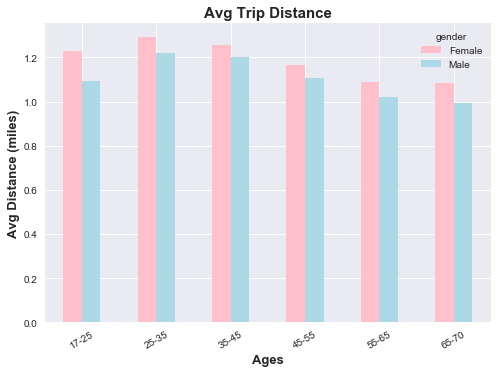

In [207]:
dis = df.pivot_table(index='age_bin', 
               columns='gender', 
               values='dis_travel',aggfunc='mean')
dis.plot.bar(color=['pink','lightblue'])
plt.xticks(rotation=30)
plt.xlabel('Ages', fontsize = 13, weight = 'bold')
plt.ylabel('Avg Distance (miles)', fontsize = 13, weight = 'bold')
plt.title('Avg Trip Distance', fontsize = 15, weight = 'bold')

Text(0.5, 1.0, 'Median Speed')

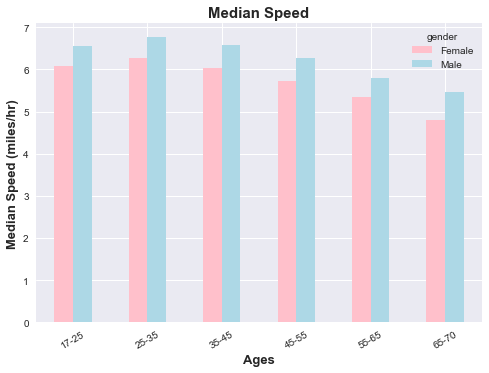

In [208]:
sp = df.pivot_table(index='age_bin', 
               columns='gender', 
               values='speed',aggfunc='median')
sp.plot.bar(color=['pink','lightblue'])
plt.xticks(rotation=30)
plt.xlabel('Ages', fontsize = 13, weight = 'bold')
plt.ylabel('Median Speed (miles/hr)', fontsize = 13, weight = 'bold')
plt.title('Median Speed', fontsize = 15, weight = 'bold')

In [209]:
df = df.drop('age_bin', axis = 1) # drop the age_bin column becasue we don't need it in the following analysis

### Data Pre-processing

In [ ]:
#missing value: already drop

In [212]:
# feature engineering
holiday = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29', '2017-07-04', 
           '2017-09-04', '2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']

df['month'] = df['start_time'].dt.month
df['day'] = df['start_time'].dt.dayofweek
df['hour'] = df['start_time'].dt.hour
df['weekend'] = np.where(df.day > 4 , 1, 0)
df['holiday'] = np.where(df.start_time.isin(holiday) , 1, 0)

In [213]:
# merge with weather data
df = df.sort_values(by = 'start_time')
df = pd.merge_asof(df,wh,left_on='start_time',right_on='DATE',
                   tolerance=pd.Timedelta('1 days'),
                   direction='nearest')

In [215]:
# skew data
df[['age','tripduration']].describe().apply(lambda x: x.apply(lambda y: "{:.2f}".format(y)))

,age,tripduration
count,2991940.00,2991940.00
mean,35.41,11.73
std,10.88,15.86
min,0.00,1.00
25%,27.00,5.93
50%,32.00,9.53
75%,41.00,15.13
max,118.00,1434.93


Policy on Divvy Bike: <br>
1. Divvy for Everyone is available to Chicago and Evanston residents ages 16 and older who qualify.
2. Time limits specified in your membership plan: 30 minutes for single ride, 3 hours for day passes and 45 minutes for annual members. Rides that go beyond those times are subject to additional fees.If you’re nearing the ride limit (30 minutes for Single Rides, 3 hours for Day Pass holders, or 45 minutes for Annual Members), we’d be happy to offer you an extra 15 minutes to find a dock

In [236]:
# age should be within 16-70 years old 
df = df[(df.age >= 16) & (df.age <= 70)]

# max time shouldn't be more than 180+15 mins
df = df[df.tripduration < 195]

# speed shouldn't be 0.0 or above 20 mph
df = df[(df.speed > 0.0) & (df.speed <= 20.0)]

# Log transform for tripduration and dis_travel
df['log_tripduration'] = np.log(df.tripduration)
df['log_dis_travel'] = np.log(df.dis_travel)

# drop 'Dependent' usertype
df = df[df.usertype != 'Dependent']

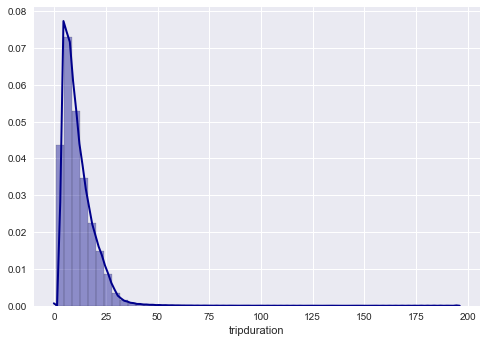

In [232]:
sns.distplot(df.tripduration, hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

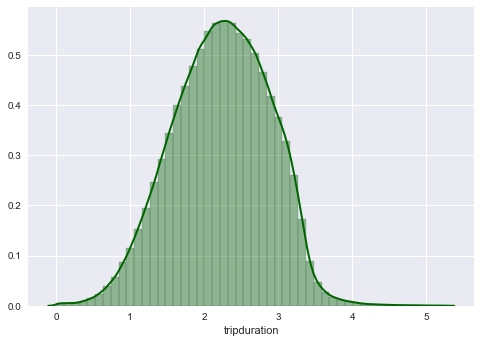

In [231]:
sns.distplot(np.log(df.tripduration), hist=True, kde=True, color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

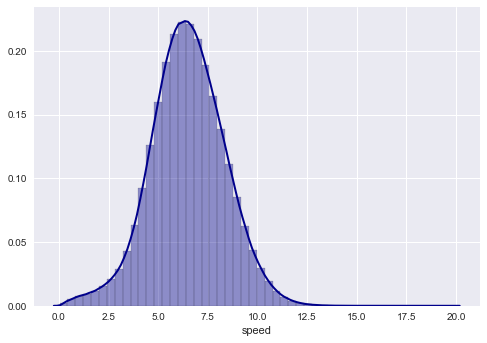

In [237]:
sns.distplot(df.speed, hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

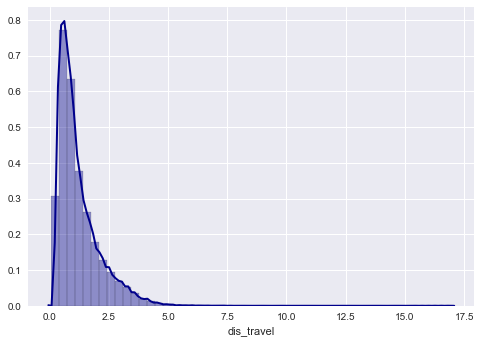

In [238]:
sns.distplot(df.dis_travel, hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

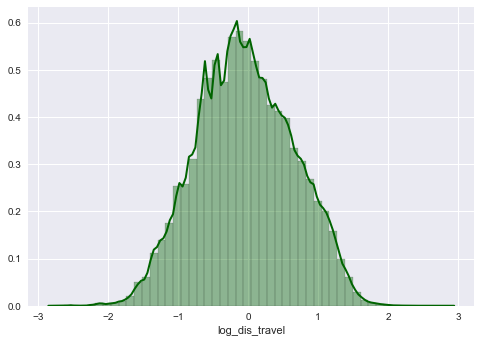

In [239]:
sns.distplot(df.log_dis_travel, hist=True, kde=True, color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

In [225]:
# One-hot encoding for usertype and gender
df = pd.get_dummies(df, columns=['usertype','gender'],prefix=['user','gender'])

In [226]:
df.head() #now the dataset looks like this

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,age,...,hour,weekend,holiday,DATE,TAVG,log_tripduration,user_Customer,user_Subscriber,gender_Female,gender_Male
0,12979231,2017-01-01 00:02:54,2017-01-01 00:08:21,3660,5.450000,28,Larrabee St & Menomonee St,20,Sheffield Ave & Kingsbury St,33.0,...,0,1,0,2017-01-01,27.0,1.695616,0,1,0,1
1,12979232,2017-01-01 00:06:06,2017-01-01 00:18:31,4992,12.416667,620,Orleans St & Chestnut St (NEXT Apts),333,Ashland Ave & Blackhawk St,32.0,...,0,1,0,2017-01-01,27.0,2.519040,0,1,0,1
2,12979233,2017-01-01 00:07:28,2017-01-01 00:12:51,5637,5.383333,287,Franklin St & Monroe St,68,Clinton St & Tilden St,27.0,...,0,1,0,2017-01-01,27.0,1.683308,0,1,0,1
3,12979234,2017-01-01 00:07:57,2017-01-01 00:20:53,2209,12.933333,300,Broadway & Barry Ave,118,Sedgwick St & North Ave,27.0,...,0,1,0,2017-01-01,27.0,2.559808,0,1,0,1
4,12979235,2017-01-01 00:10:44,2017-01-01 00:21:27,670,10.716667,47,State St & Kinzie St,175,Wells St & Polk St,47.0,...,0,1,0,2017-01-01,27.0,2.371800,0,1,0,1


In [240]:
df.shape

(2934629, 31)

In [227]:
# export the dataset
df.to_csv("Divvy_Trips_Model.csv", index=False)